In [1]:
from rw_ve_plot import *
import matplotlib.pyplot as plt
import pandas as pd
%load_ext autoreload
%autoreload 2
plt.style.use(r"./RW_visualization.mplstyle")


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# import warnings filter
# from pandas.core.common import SettingWithCopyWarning
import warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.options.mode.chained_assignment = None 

In [3]:
# df1 = pd.read_excel(r'C:\Users\dipes\python\jupyter_notebook_files\Vaccine details.xlsx')
vaccine_detail = pd.read_excel('vaccine_details.xlsx')
# vaccine_detail = pd.read_excel('./Vaccine/RW_vaccine_details.xlsx')
vaccine_detail.columns = vaccine_detail.columns.str.strip().str.lower().str.replace(' ', '_').\
    str.replace('(', '').str.replace(')', '')

# Drop rows if efficacy does not exist
vaccine_detail = vaccine_detail[vaccine_detail['efficacy_in_%'] != 'X']

# Remove all vaccine
vaccine_detail = vaccine_detail[vaccine_detail.vaccine!='All vaccine']

/usr/lib/python3/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


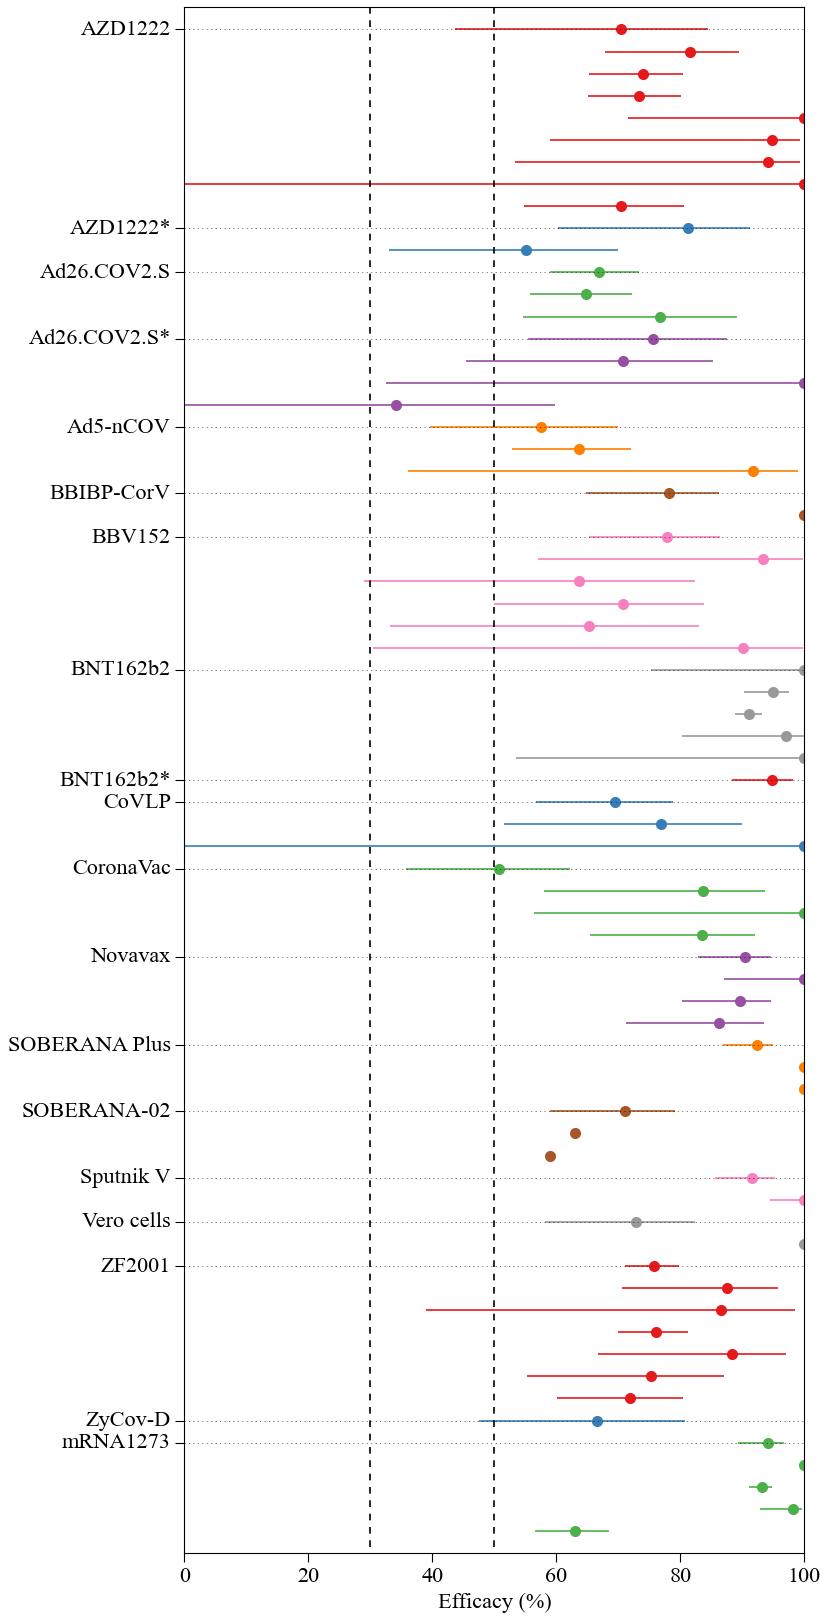

In [4]:
plot_vaccine_efficacy(vaccine_detail, save_figure=False)

Alpha


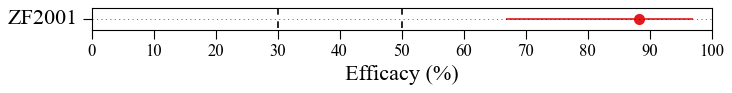

Beta


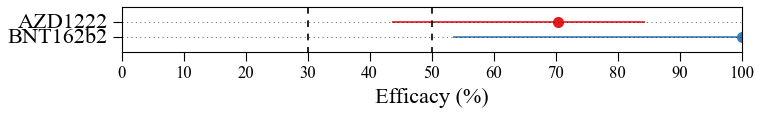

Delta


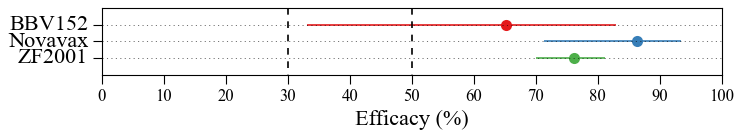

Kappa


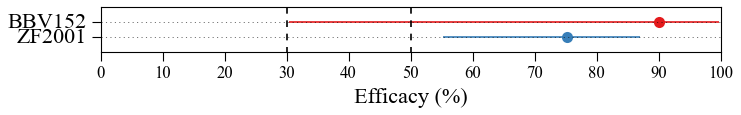

Mixed variants


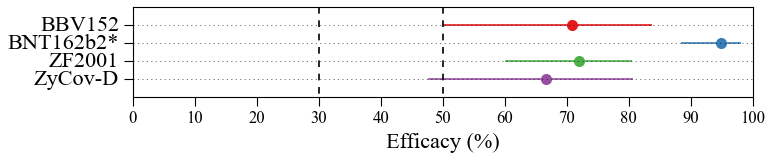

Non beta


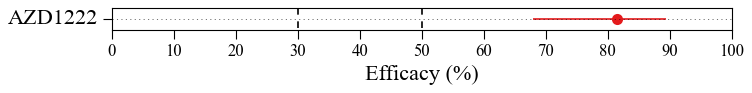

SARS-CoV-2


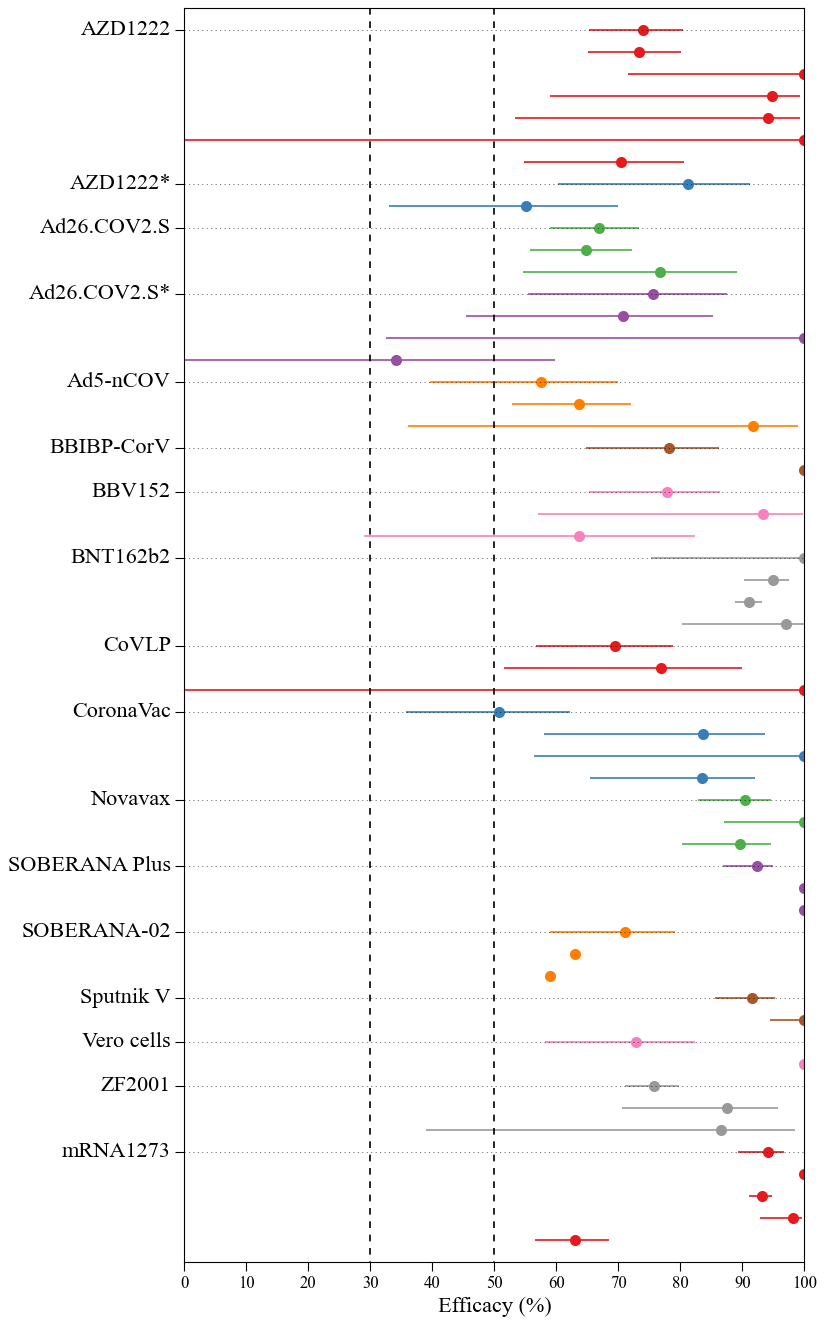

In [5]:
plot_vaccine_efficacy_variants_group(vaccine_detail, save_figure=False)

Symptomatic


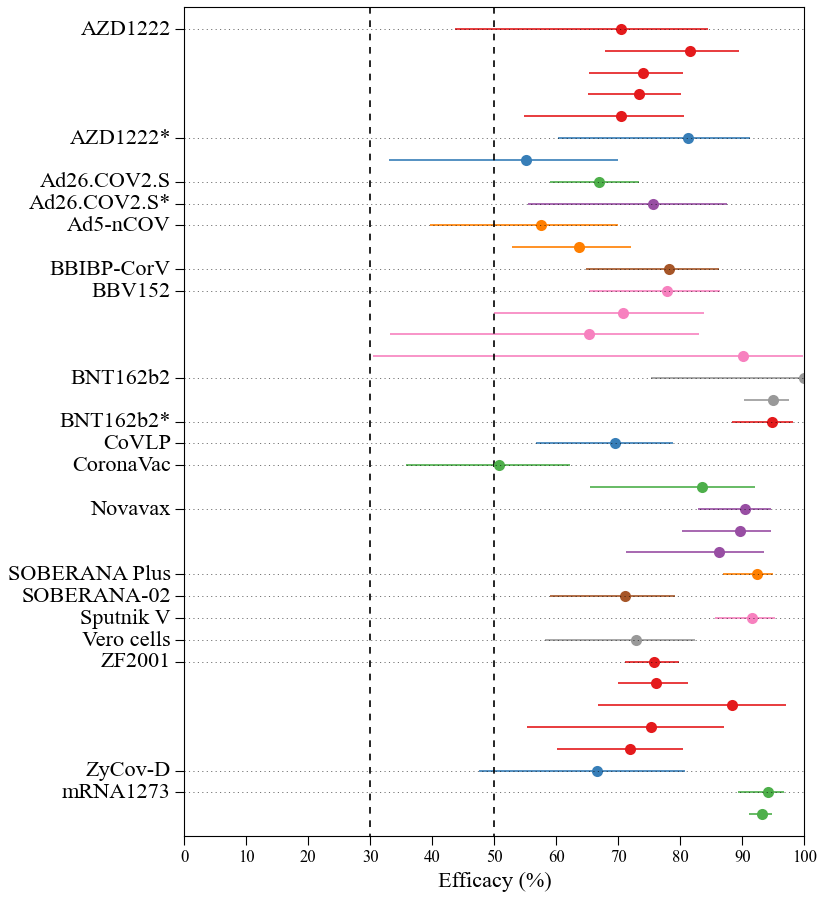

Severe


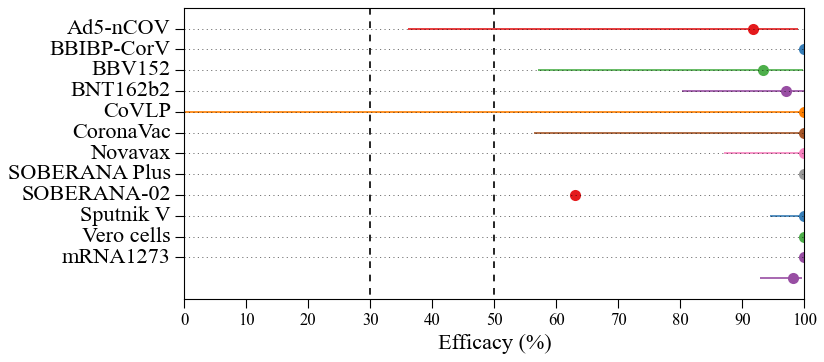

Critical


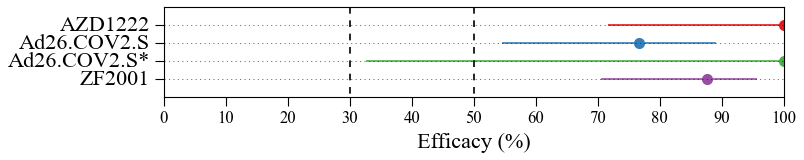

Death


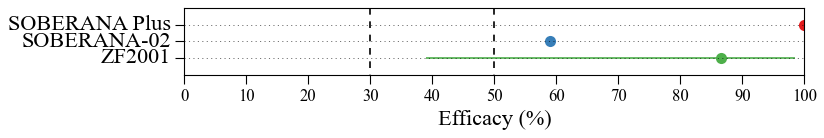

Asymptomatic


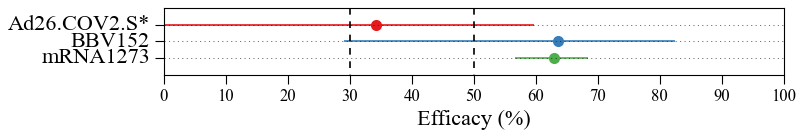

ED


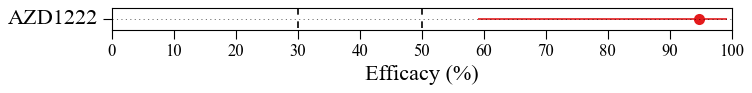

Hospitalization


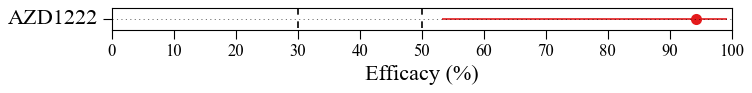

ICU


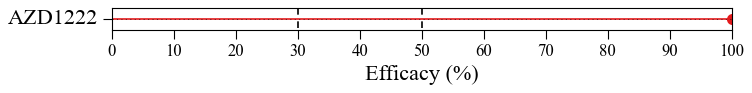

Moderate


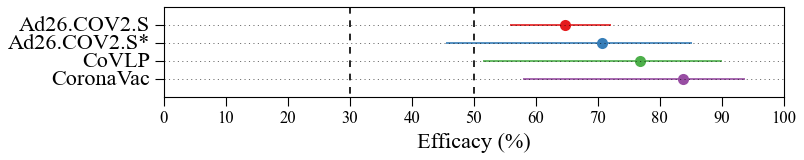

Documented infection


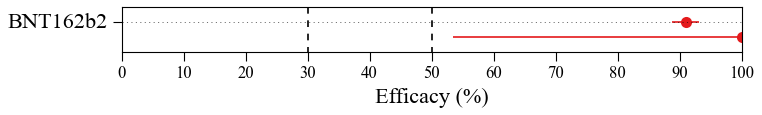

In [6]:
plot_vaccine_efficacy_ave_group(vaccine_detail, save_figure=False)

Symptomatic
70.4
43.6 84.5
81.5
67.9 89.4
70.8
50 83.8
65.2
33.1 83
90.1
30.4 99.8
94.8
88.4 98.1
86.3
71.3 93.5
76.1
70 81.2
88.3
66.8 97
75.2
55.3 87
71.9
60.1 80.5
66.6
47.6 80.7


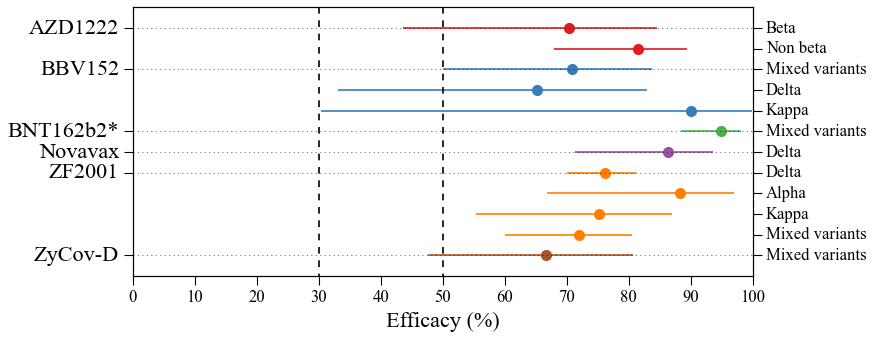

Documented infection
100.0
53.5 100


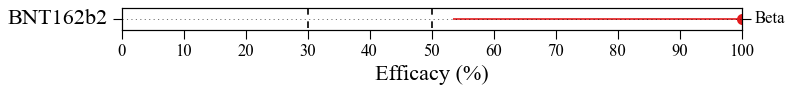

In [7]:
plot_vaccine_efficacy_ave_group_for_variants(vaccine_detail, save_figure=False)

Symptomatic
Alpha


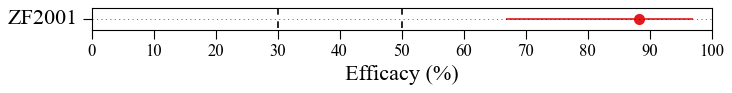

Beta


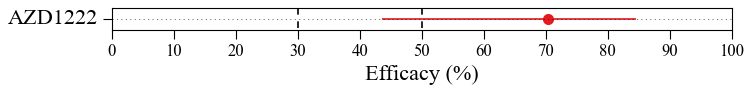

Delta


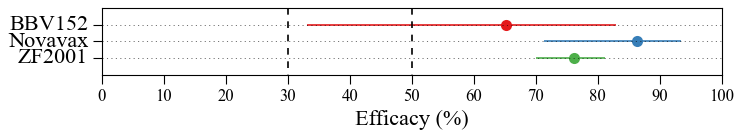

Kappa


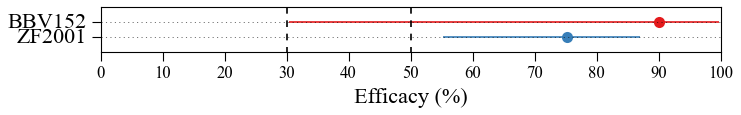

Mixed variants


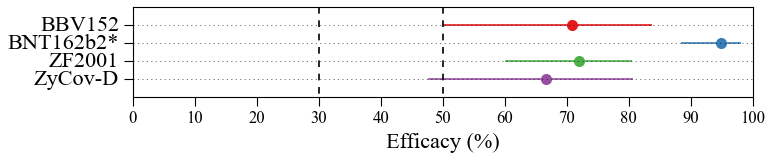

Non beta


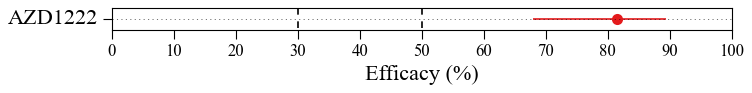

SARS-CoV-2


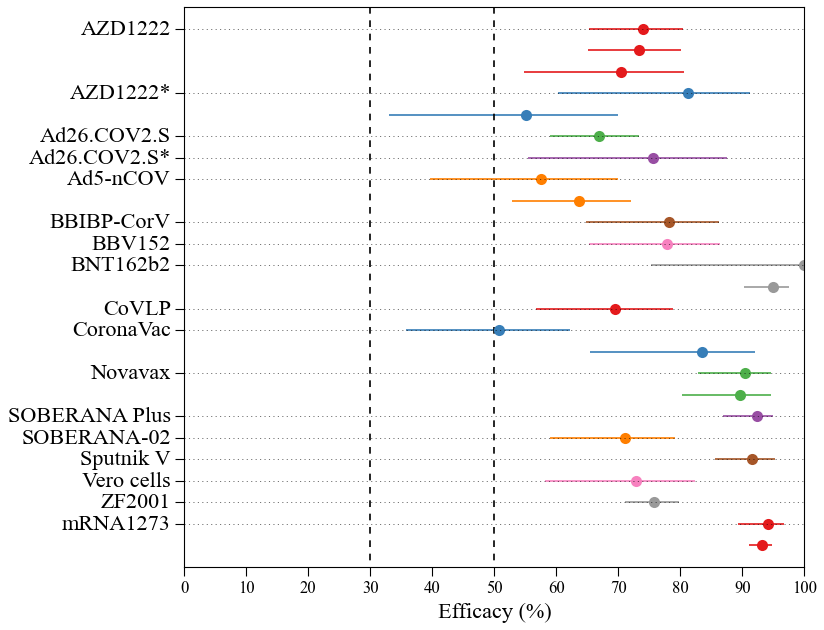

Severe
SARS-CoV-2


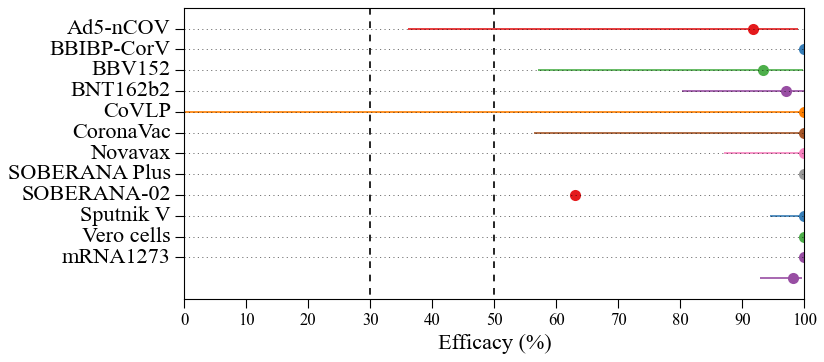

Critical
SARS-CoV-2


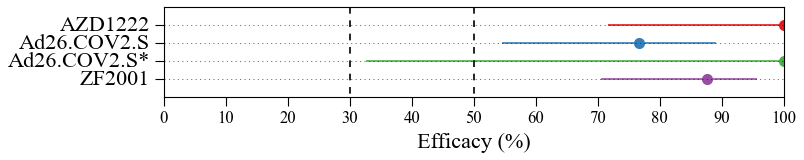

Death
SARS-CoV-2


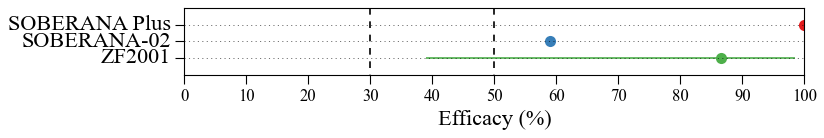

Asymptomatic
SARS-CoV-2


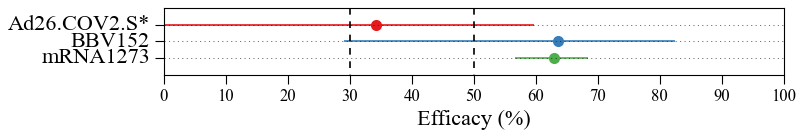

ED
SARS-CoV-2


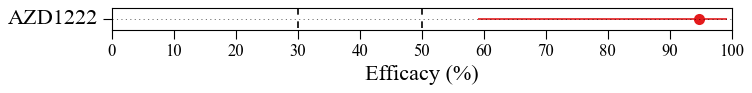

Hospitalization
SARS-CoV-2


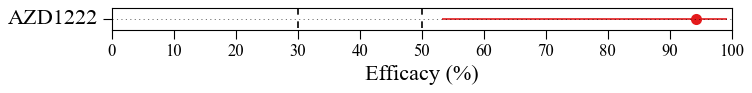

ICU
SARS-CoV-2


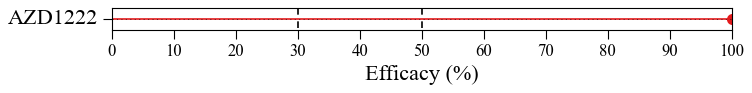

Moderate
SARS-CoV-2


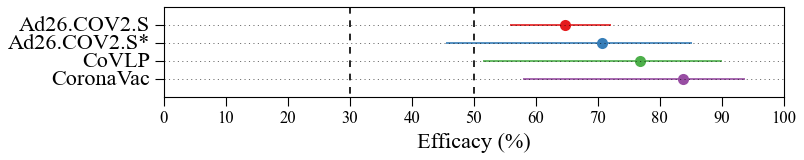

Documented infection
Beta


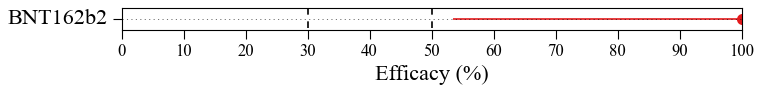

SARS-CoV-2


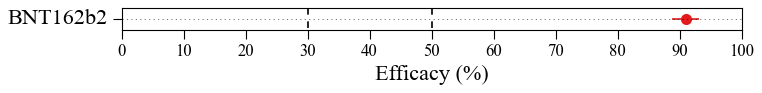

In [8]:
plot_vaccine_efficacy_variants_and_ave_group(vaccine_detail, save_figure=False)

Average vaccine efficacy

C:\Users\GIGABYTE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


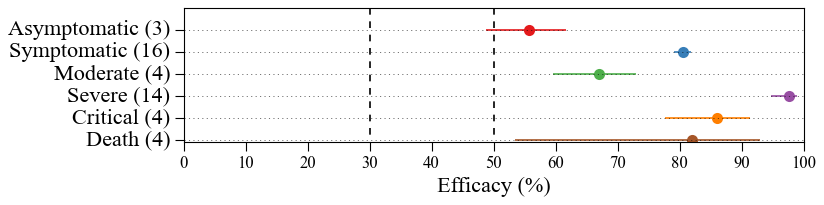

In [9]:
# df1 = pd.read_excel(r'C:\Users\dipes\python\jupyter_notebook_files\Vaccine details.xlsx')
vaccine_detail = pd.read_excel('vaccine_details.xlsx')
# vaccine_detail = pd.read_excel('./Vaccine/RW_vaccine_details.xlsx')
vaccine_detail.columns = vaccine_detail.columns.str.strip().str.lower().str.replace(' ', '_').\
    str.replace('(', '').str.replace(')', '')

# Drop rows if efficacy does not exist
vaccine_detail = vaccine_detail[vaccine_detail['efficacy_in_%'] != 'X']

plot_average_vaccine_efficacy(vaccine_detail, save_figure=False)

Use my reproduced vaccine efficacy

In [10]:
# Run vaccine_efficacy_CIs.ipynb to update the data
# df1 = pd.read_excel(r'C:\Users\dipes\python\jupyter_notebook_files\Vaccine details.xlsx')
vaccine_detail = pd.read_excel('rw_vaccine_details.xlsx')
# vaccine_detail = pd.read_excel('./Vaccine/RW_vaccine_details.xlsx')
vaccine_detail.columns = vaccine_detail.columns.str.strip().str.lower().str.replace(' ', '_').\
    str.replace('(', '').str.replace(')', '')

# Remove all vaccine
vaccine_detail = vaccine_detail[vaccine_detail.vaccine!='All vaccine']

In [11]:
# Replace the vaccine efficacy and Ci by my estimations
vaccine_detail['efficacy_in_%'] = vaccine_detail['rw_efficacy_in_%']
vaccine_detail['lower'] = vaccine_detail['rw_lower']
vaccine_detail['upper'] = vaccine_detail['rw_upper']

In [12]:
# Drop empty vaccine efficacy
vaccine_detail = vaccine_detail[~np.isnan(vaccine_detail['efficacy_in_%'])]

Symptomatic
72.81647692133481
63.83440874587205 79.56776313220153
72.61154706395239
63.7633764106432 79.29919291789597
70.18449907673737
55.25654664851773 80.13197398238762
81.35601959267854
60.60268674396234 91.17711395268007
54.34988499526451
32.04096892784178 69.3354515644451
66.56308371540159
58.81975192236399 72.85039739159764
75.37836077075346
55.67848689612656 86.32210238593612
56.85957102387697
38.89186182612747 69.54421018443581
63.5646332657832
52.74855243396457 71.90486180975519
77.90622862391776
64.57870538837352 86.21917298702097
77.27563295861796
64.64351915948723 85.3945628876123
100.0
0.0 0.0
95.6774208216811
90.79023089062545 97.97120964370137
68.01855226105683
54.38153064198021 77.57897154655535
50.25261265418747
35.61832273629254 61.56045240018346
84.90069214565152
68.40330878435911 92.78439960297074
88.87648935330785
80.1605085173896 93.76332356020683
89.58195710573833
80.03365800009902 94.56407098770447
90.0298113496897
83.07018115428563 94.12842732526107
72.389332

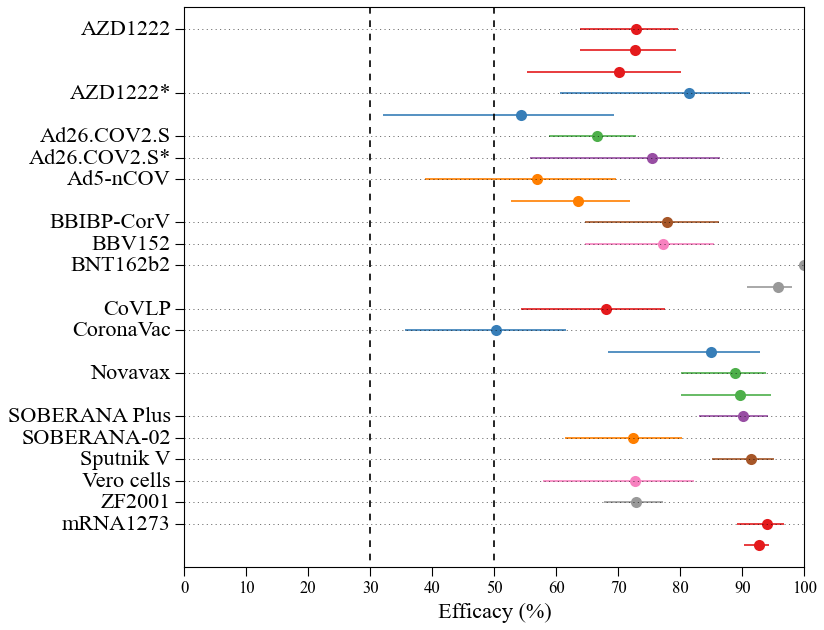

Critical
100.0
0.0 0.0
76.59415860078111
58.13734470125546 86.91355319685567
100.0
0.0 0.0
86.10950955560672
67.37701053188043 94.08559031739459


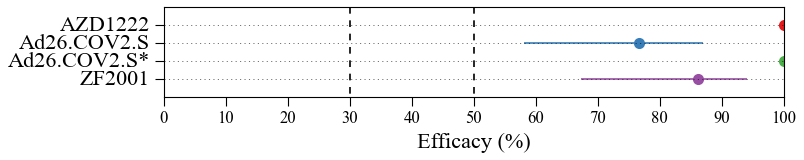

Death
100.0
0.0 0.0
62.67744067914551
-40.65671476080679 90.0966446100528
83.4085808580858
25.882132651922 96.2859807089442


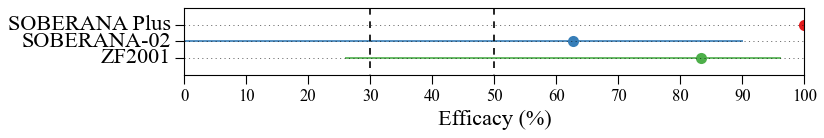

Severe
93.30893637114862
49.35560766084289 99.11598638235171
96.59125930297367
75.00569400062713 99.53511359187748
100.0
0.0 0.0
100.0
0.0 0.0
100.0
0.0 0.0
100.0
0.0 0.0
66.824391714796
-64.34711906813556 93.30307101618862
100.0
0.0 0.0
98.11357972005156
92.35965000277866 99.5342384218138


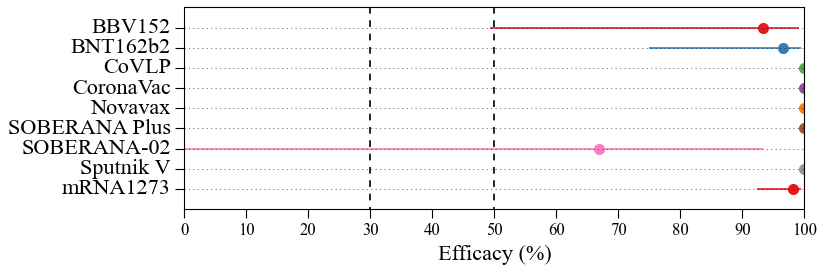

Asymptomatic
33.42107759438436
0.2652253072337074 55.5545904390107
63.11669652186893
30.05841761445521 80.5497955713814
57.03658872454774
49.6515099307723 63.33842969499857


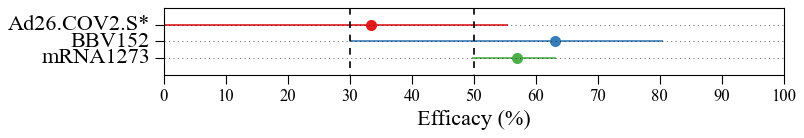

ED
94.6212206998075
57.55023087685537 99.31845879594184


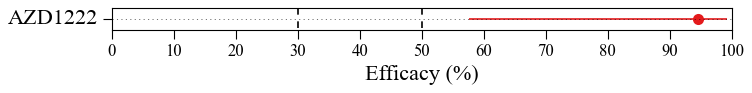

Hospitalization
93.94887328728343
51.62524721192221 99.24307345499498


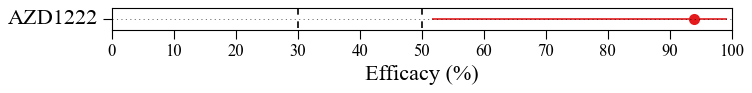

ICU
100.0
0.0 0.0


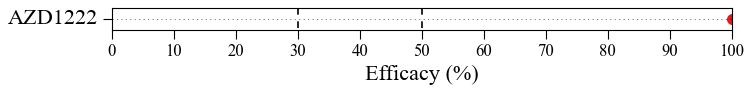

Moderate
64.4732764476142
55.5104771873441 71.630442257551
70.34211638295302
45.94237724206511 83.72865812873371
75.77163050080063
47.5679106715358 88.80430102809086
100.0
0.0 0.0


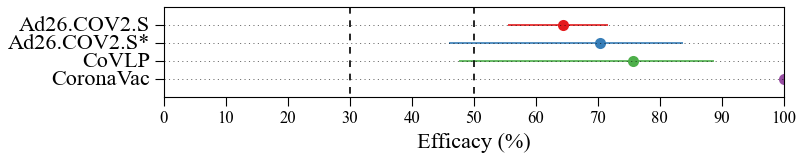

Documented infection
90.51175269899888
88.09583267967565 92.43736798866651


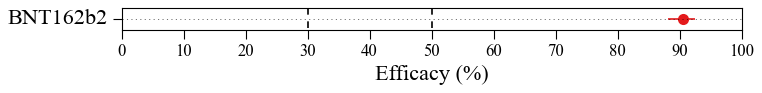

In [13]:
plot_vaccine_efficacy_ave_group_for_original(vaccine_detail, save_figure=False)

Symptomatic
69.67483506126295
42.27468888425425 84.06910918647674
81.04677191328935
67.15445679650007 89.06320858567504
70.38381672475622
49.94131107243324 82.47820047660475
64.73628628037788
33.7081398936618 81.24159582632423
89.96340455672294
21.61104162628719 98.7149561598743
94.68206091772153
87.92089778762532 97.65872698271794
73.30542618507661
66.6060670704175 78.66078629722809
87.15503034174385
63.62188125253424 95.46449208473663
71.82589202316458
50.04620142982235 84.10970971156001
68.98125986511694
56.35839106041583 77.9530988216455
67.29275900975642
45.83628760237287 80.24944070782092


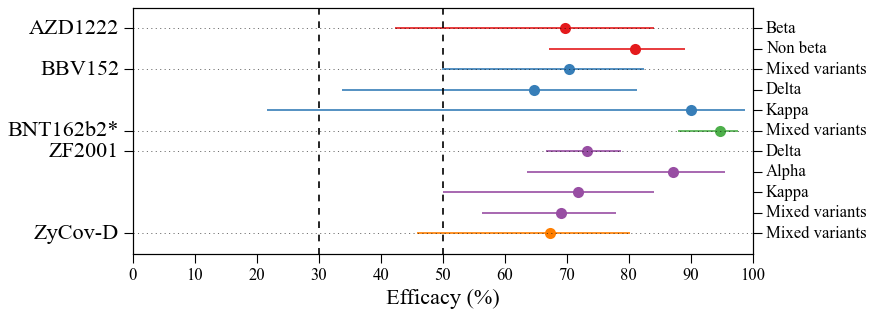

In [14]:
plot_vaccine_efficacy_ave_group_for_variants(vaccine_detail, save_figure=False)